# Importing required libraries

In [2]:
import os
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from mlflow.types.schema import Schema, ColSpec
from sklearn.metrics import mean_squared_error, r2_score
from mlflow.models.signature import ModelSignature
from mlflow.models.signature import infer_signature


In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Exploratory Data Analysis (EDA) 

## Loading data and displaying first 5 rows

In [6]:
housing = pd.read_csv('../data/raw/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Dataset Information

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Dataset Basic Statistics

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Checking for missing data in the dataset

In [12]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

**Observation:** There are null values in the total_bedrooms column and needs to be preprocessed. Proceeding with imputing with Median and would be using other methods (mode, drop rows to create new versions for data tracking)

_**Imputing**_ `total_bedrooms` column and separating the _**target_variable**_ `median_house_value`

In [15]:
median_order = housing.groupby('ocean_proximity')['median_house_value'].median().sort_values(ascending=False)
sorted_categories = median_order.index
housing.loc[housing['total_bedrooms'].isna(), 'total_bedrooms'] = housing['total_bedrooms'].median()
target_variable = housing['median_house_value']
housing.drop('median_house_value', axis=1, inplace=True)

## Visualizing Distribution of target variable

Text(0, 0.5, 'Frequency')

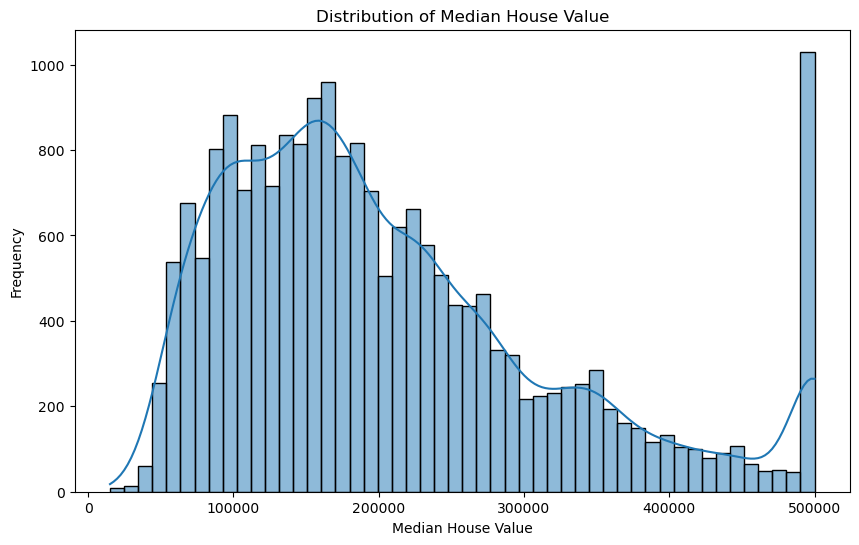

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(target_variable, kde=True, bins=50)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')

## Visualizing the distribution of all features

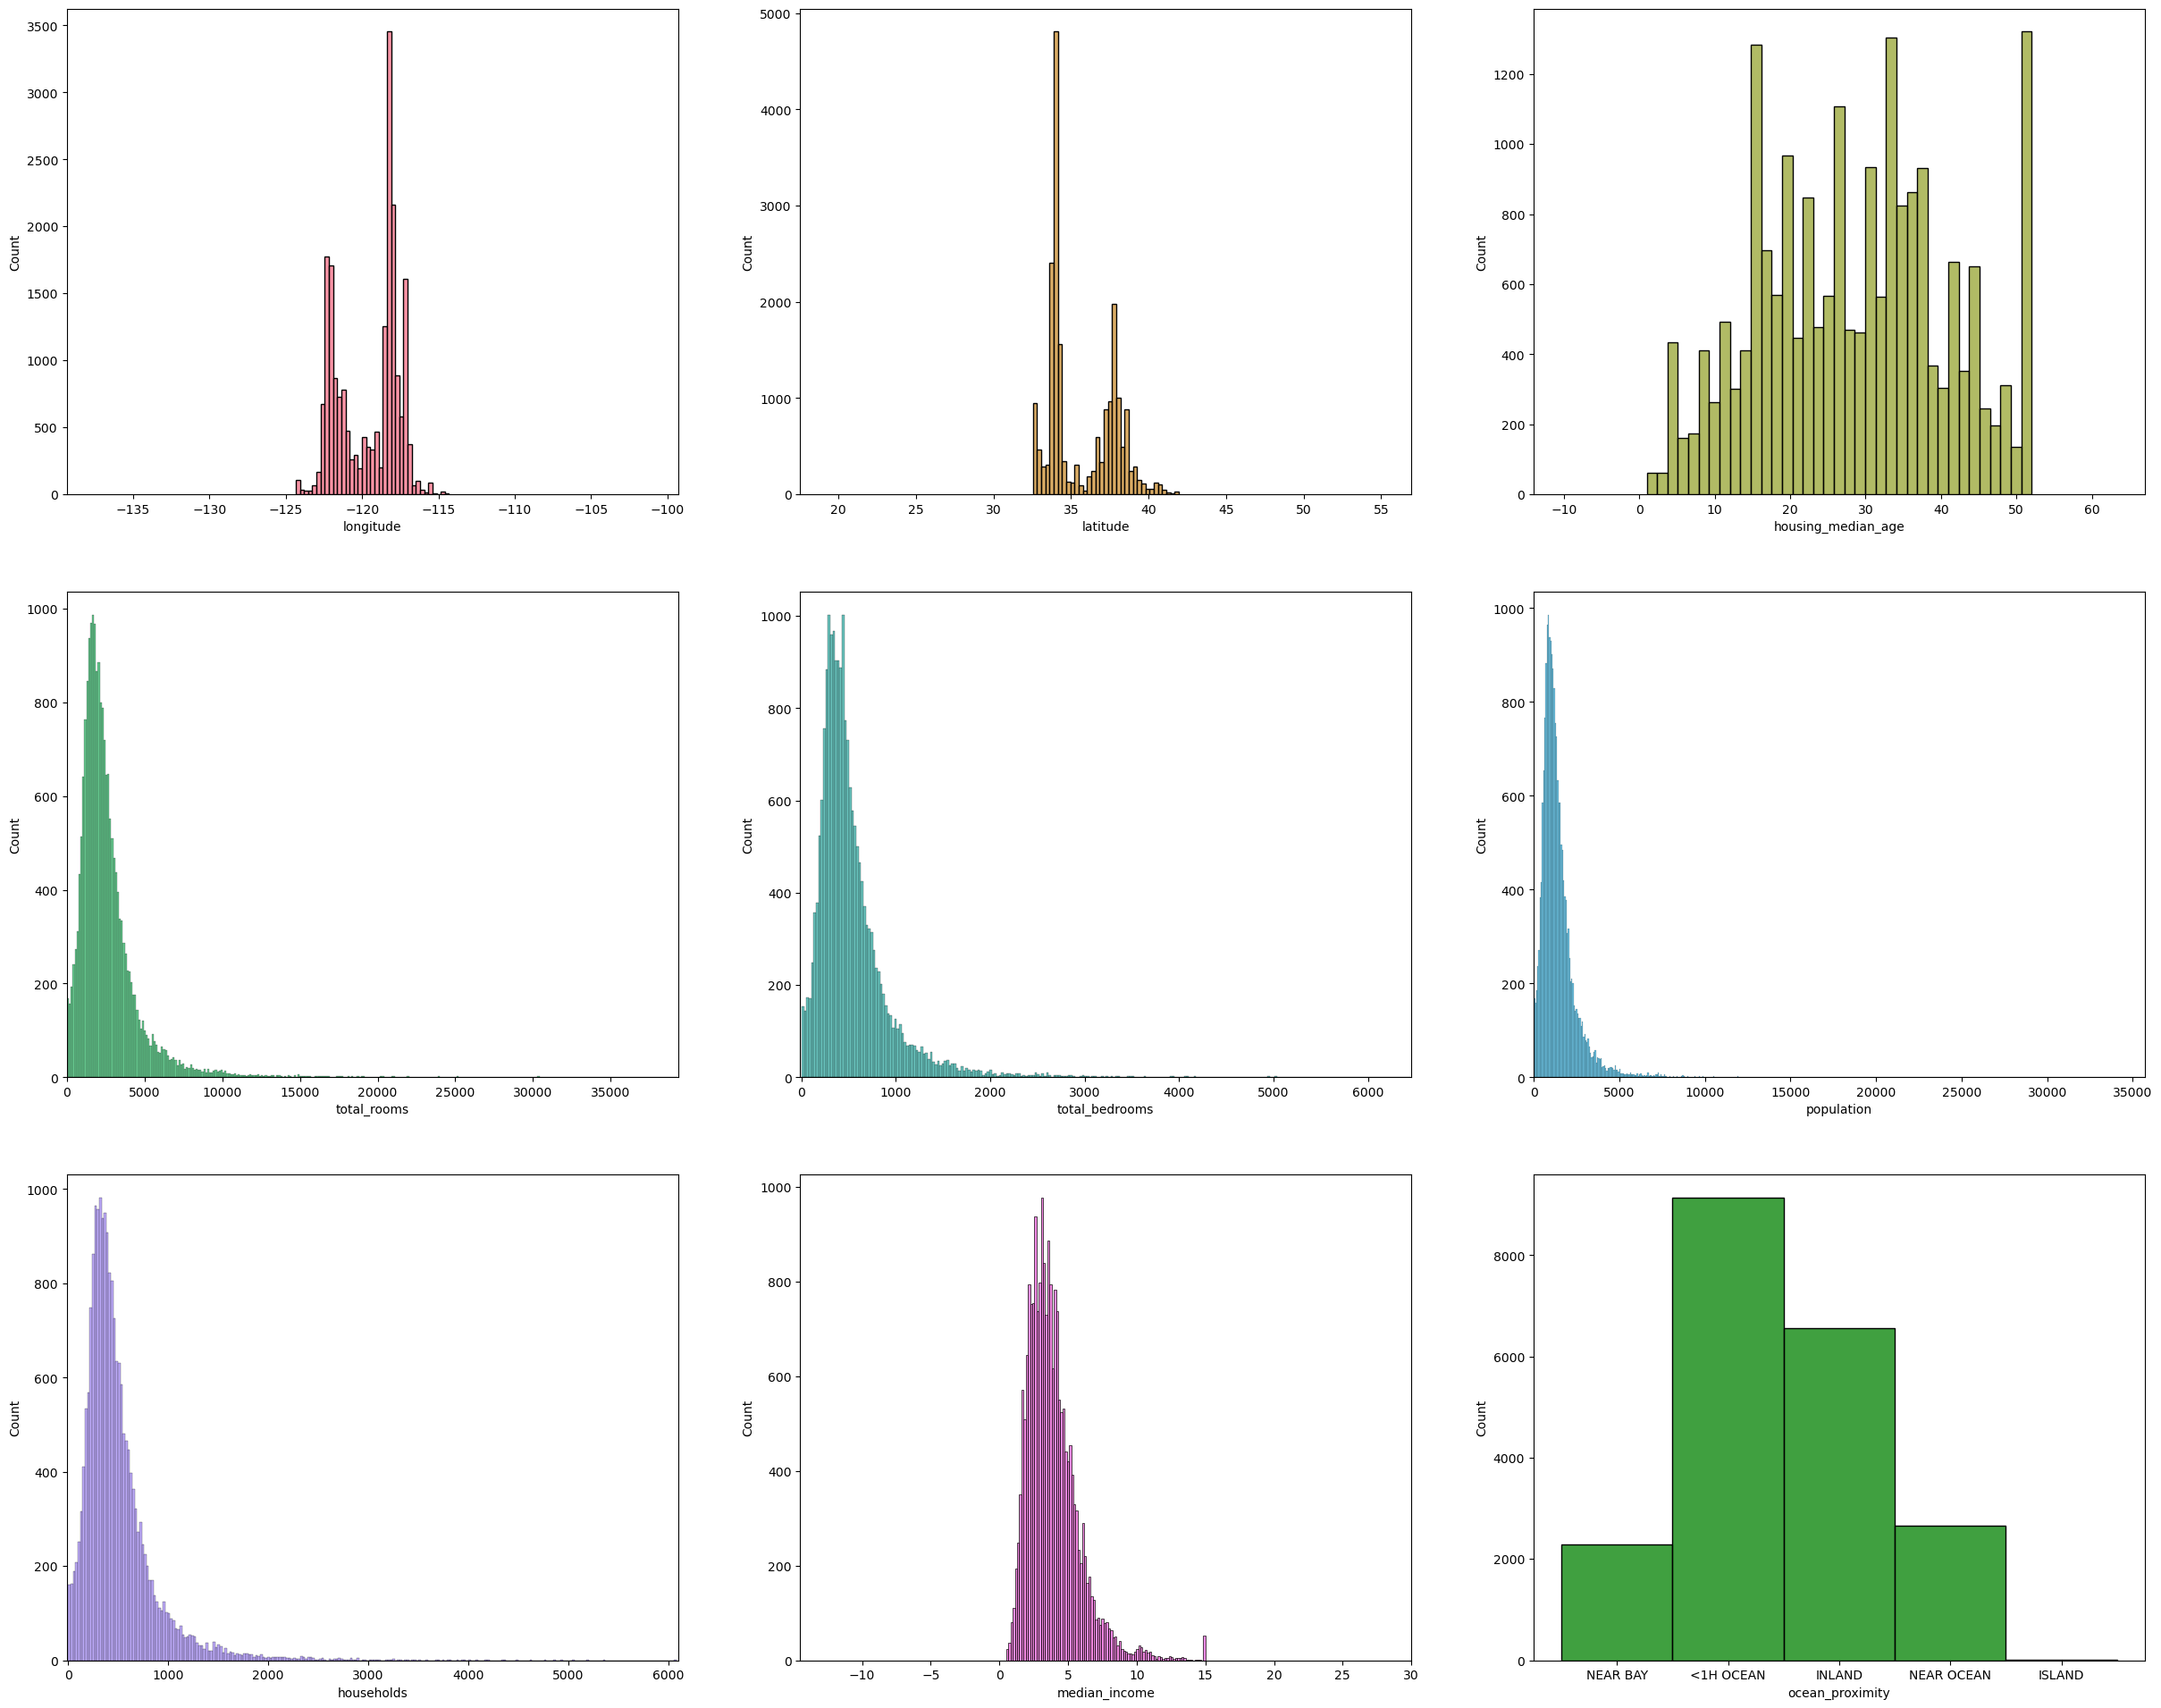

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(30, 24))
colors = sns.color_palette("husl", 8).as_hex() + ['green']
for column, ax, color in zip(housing.columns, axes.flatten(), colors):
    sns.histplot(housing, x=column, ax=ax, color=color)
    if not isinstance(housing[column].loc[0], str):
        ax.set_xlim(min(housing[column]) - 15, max(housing[column]) + 15)

## GeoSpatial plot of Latitude and Longitude

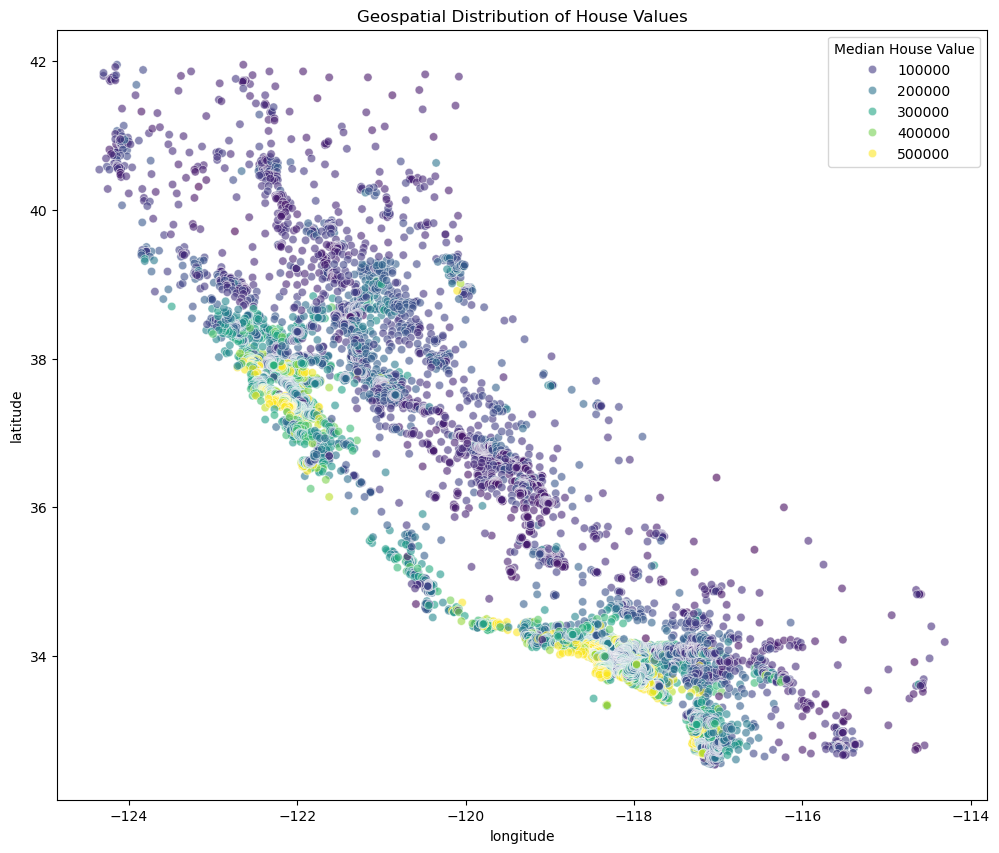

In [21]:
plt.figure(figsize=(12, 10))

sns.scatterplot(
    data=housing,
    x='longitude',
    y='latitude',
    hue=list(target_variable),
    palette='viridis',
    alpha=0.6,
    sizes=housing['population']/100
)

plt.title('Geospatial Distribution of House Values')
plt.legend(title='Median House Value')

## Correlation heatmap to visualize if any numeric fetaures have correlation 

Text(0.5, 1.0, 'Correlation Matrix of Housing Features')

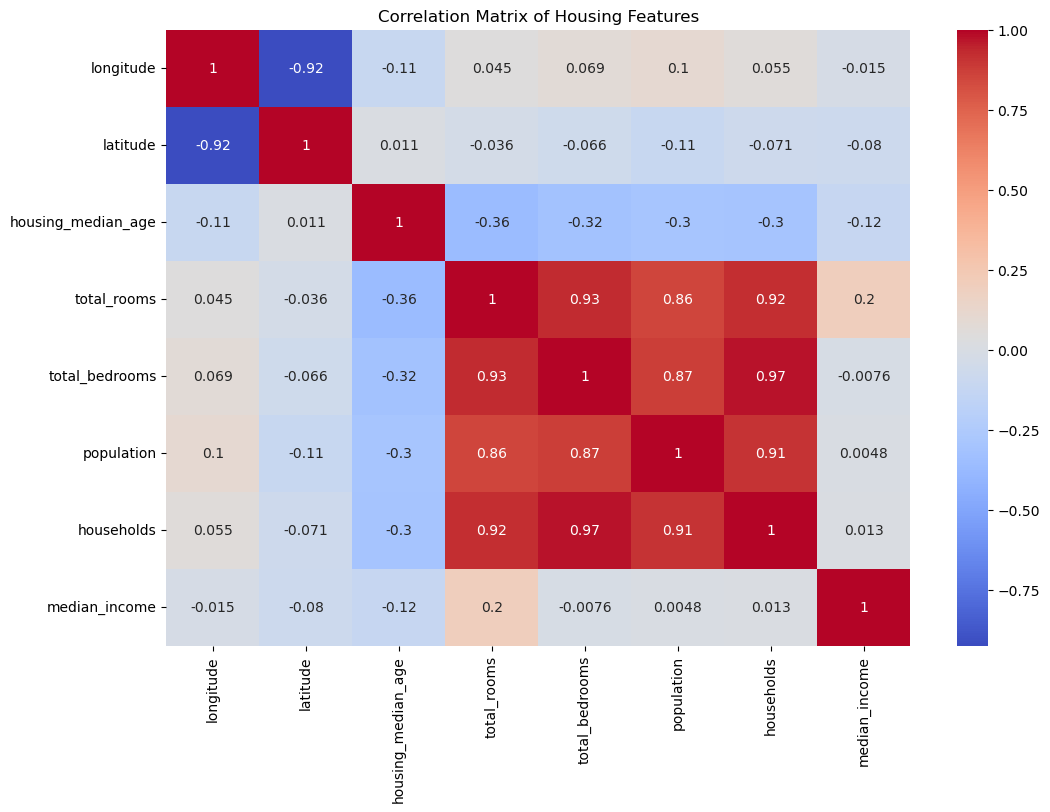

In [23]:
plt.figure(figsize=(12, 8))
corr_matrix = housing[housing.columns[:-1]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Housing Features')

## Pair plot of Features with target variable to see correlation among them

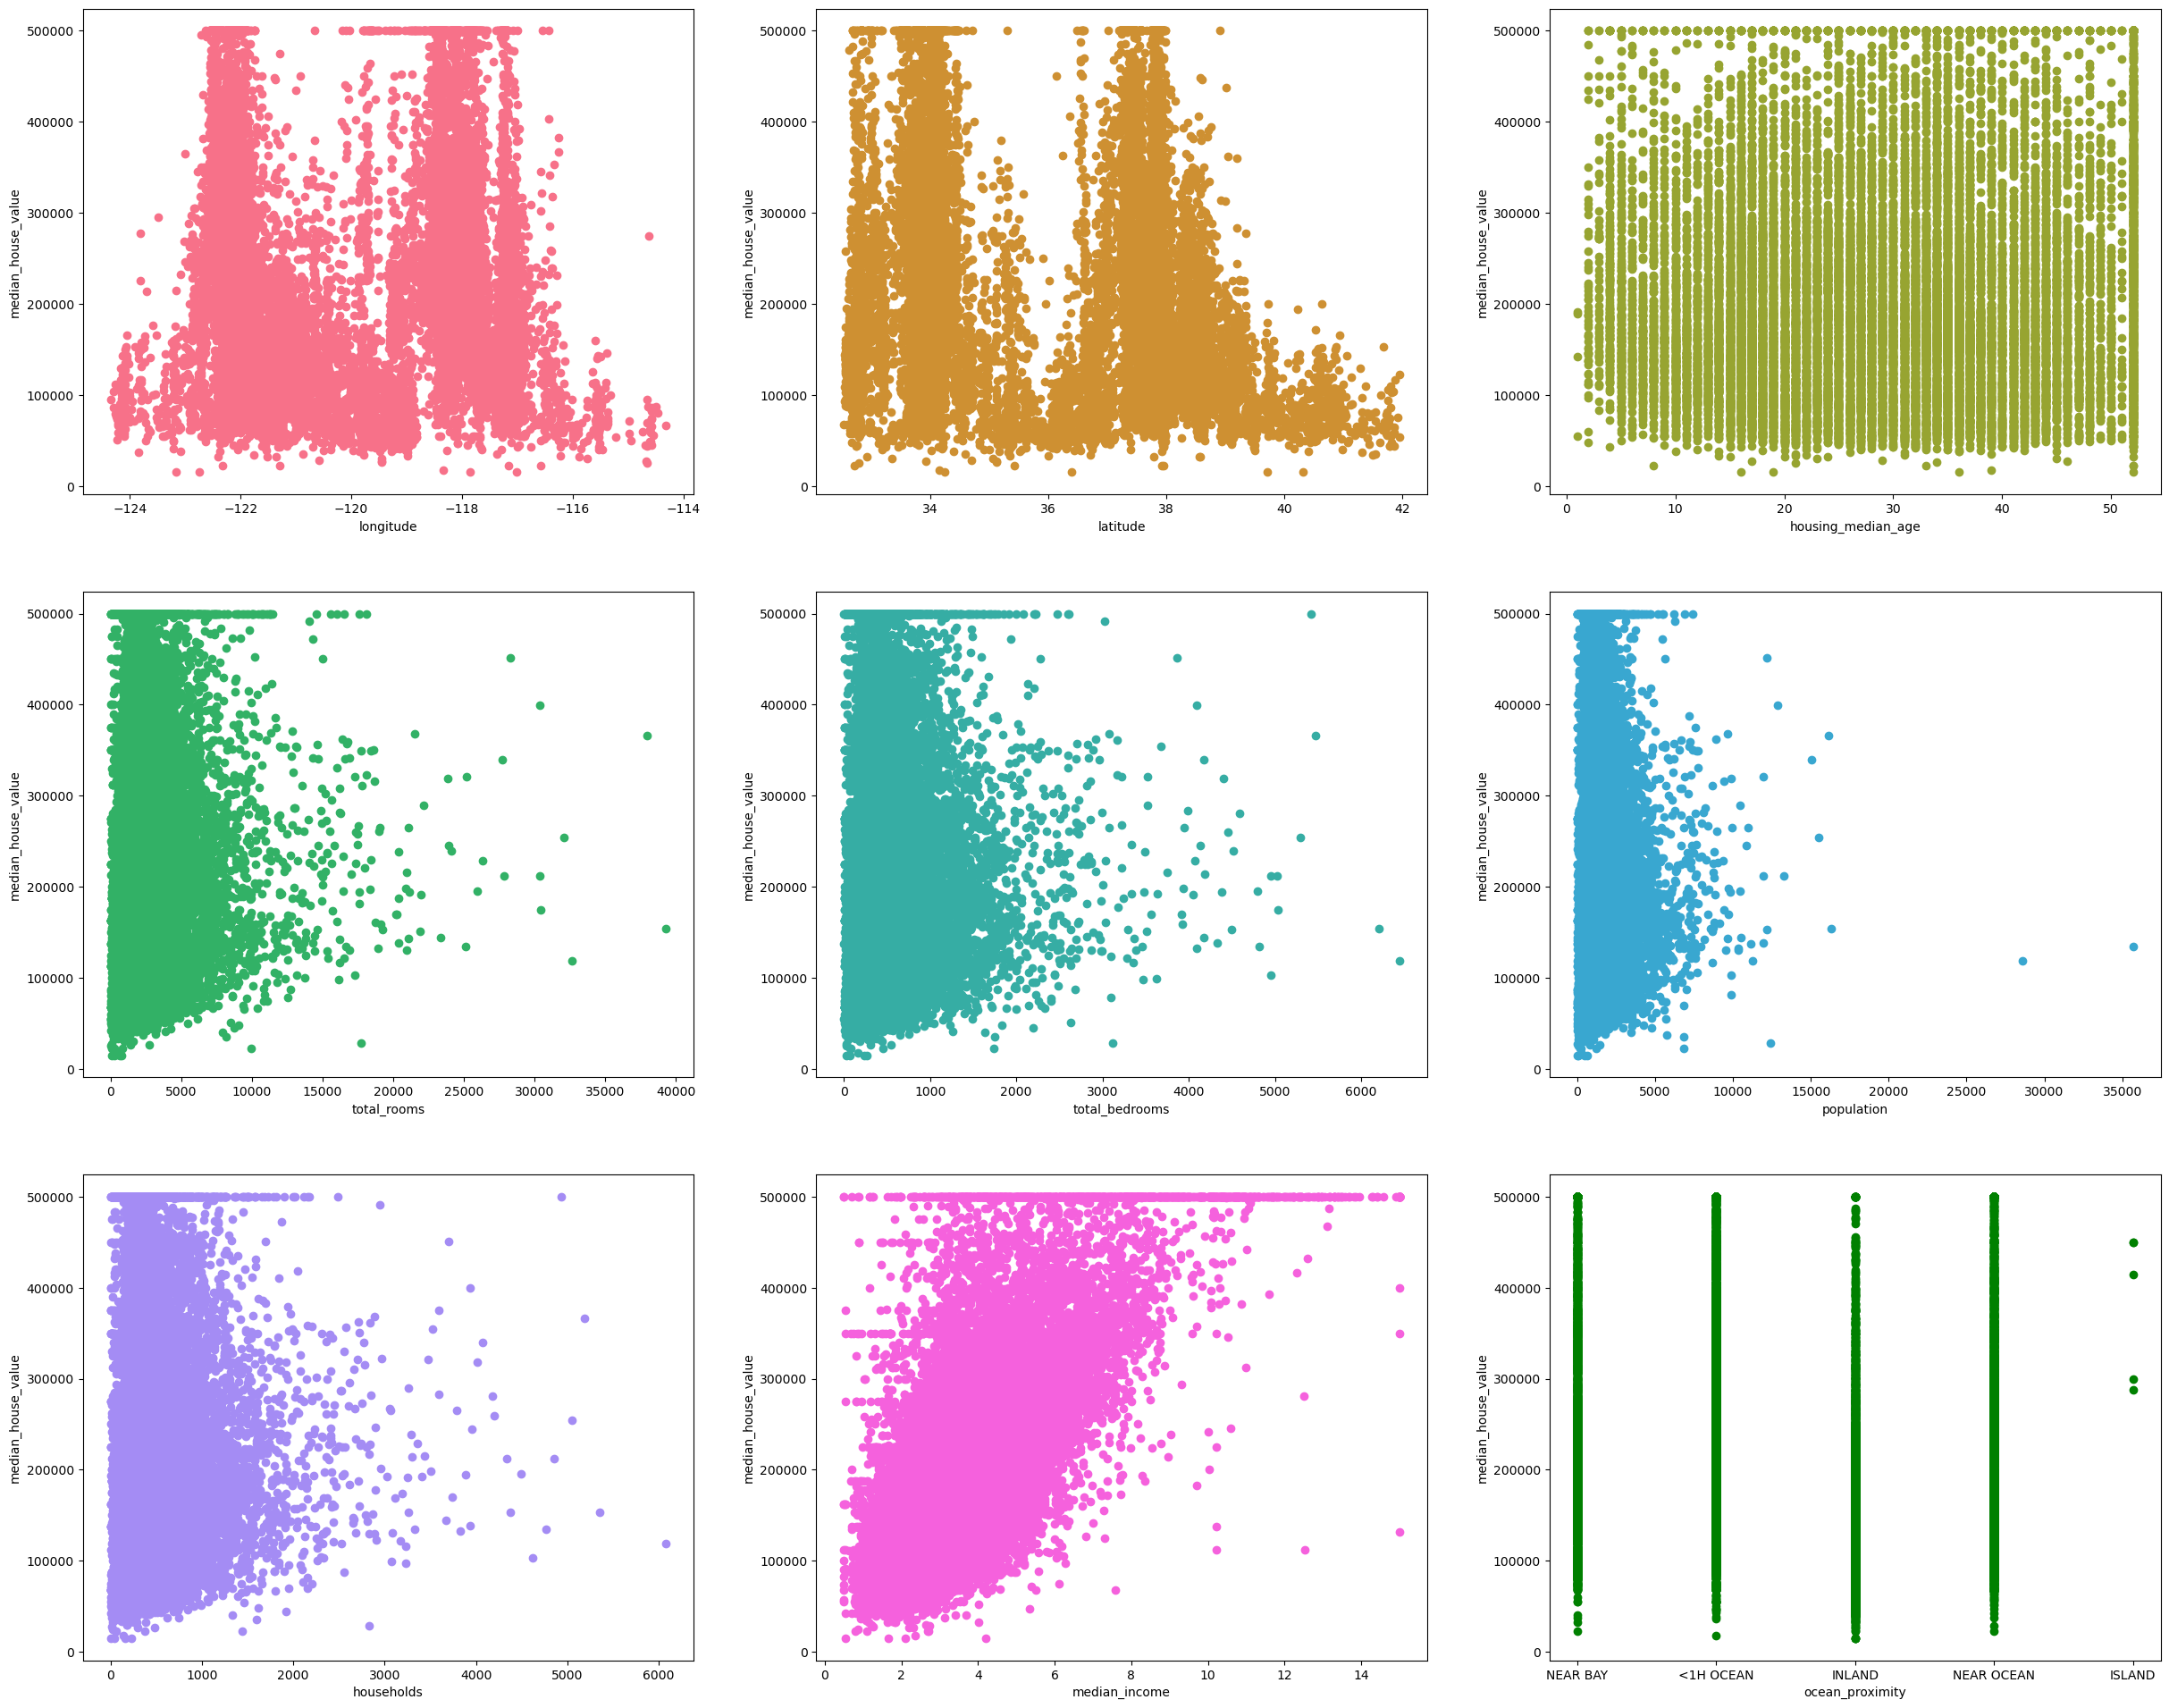

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(30, 24))
for column, ax, color in zip(housing.columns, axes.flatten(), colors):
    ax.scatter(housing[column], target_variable, color=color)
    ax.set_xlabel(column)
    ax.set_ylabel('median_house_value')

### Analyzing ocean_proximity relation with target_variable

/var/folders/x3/v9kj5dt12yj07dw_h84r283c0000gn/T/ipykernel_82740/3518807582.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/x3/v9kj5dt12yj07dw_h84r283c0000gn/T/ipykernel_82740/3518807582.py:2: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.boxplot(


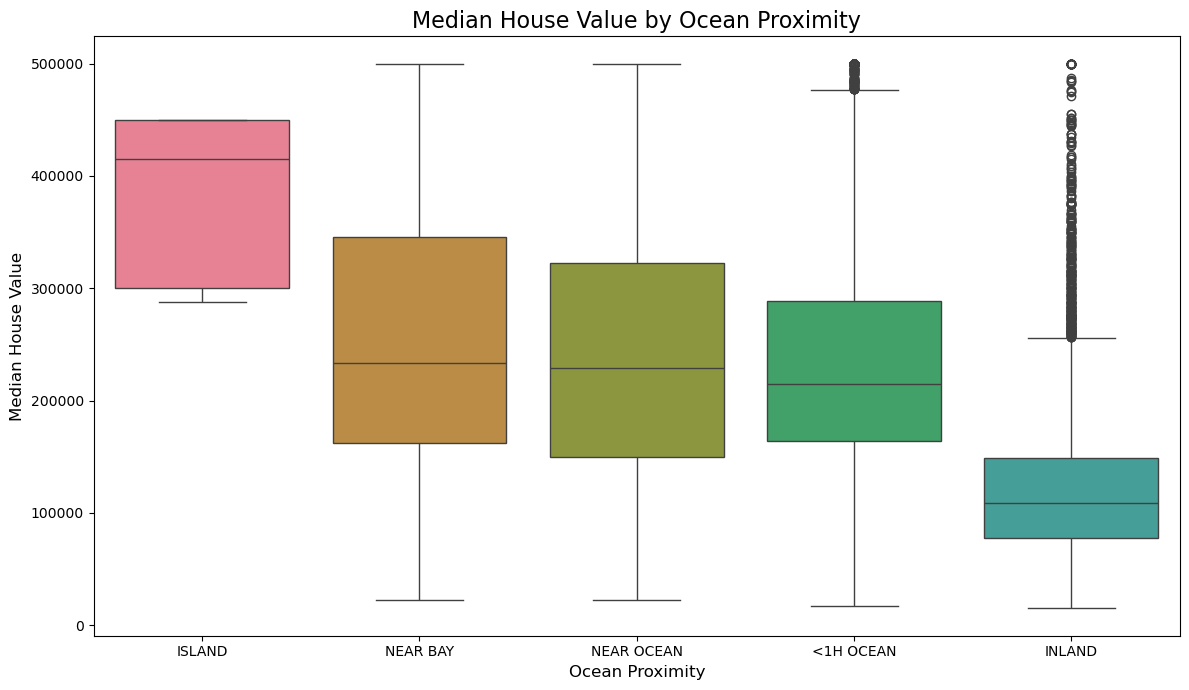

In [27]:
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=housing, 
    x='ocean_proximity', 
    y=target_variable,
    order=sorted_categories,
    palette=colors
)
    
plt.title('Median House Value by Ocean Proximity', fontsize=16)
plt.xlabel('Ocean Proximity', fontsize=12)
plt.ylabel('Median House Value', fontsize=12)
plt.tight_layout()

### Observation:
#### For a Linear Regression Model

This model requires features that have a linear relationship with the target and are not redundant.

##### Features to Use As-Is
* **Features**: `median_income`, `housing_median_age`, `total_rooms`
* **Reasoning**: `median_income` is kept because the **heatmap and scatter plot** both confirm it's the strongest linear predictor. `housing_median_age` is kept because it provides a unique, non-redundant signal, even if it's weak. `total_rooms` is kept as a simple, single representative for the concept of "block size" after its highly correlated peers are dropped.

##### Features to Drop
* **Features**: `total_bedrooms`, `population`, `households`
* **Reasoning**: The **correlation heatmap** shows these are highly correlated with `total_rooms` (multicollinearity), making them redundant for a linear model. The **scatter plots** confirm they are weak individual predictors. Dropping them is the simplest way to reduce model complexity and instability caused by this redundancy.

##### Features to Feature Engineer
* **Features**: `latitude`, `longitude`, `ocean_proximity`
* **Reasoning**: Their relationship with price is not linear, which a Linear Regression model cannot handle raw. The **geospatial scatter plot** shows clear location-based price patterns. Therefore, their only value to this model is if they are engineered into a new, more linear feature (e.g., a "location cluster" that is then one-hot encoded, or a "distance from coast" feature). ocean_proximity boxplot plot shows the __"INLAND"__ category has a much lower median price than the __"NEAR BAY"__ or __"<1H OCEAN"__ categories.

***

#### For a Decision Tree Model

This model is robust to non-linear relationships and redundant features, so the strategy is different.

##### Features to Use As-Is
* **Features**: `median_income`, `housing_median_age`, `latitude`, `longitude`
* **Reasoning**: A Decision Tree can effectively use all of these raw. The **scatter plots** show that even though the relationships for `housing_median_age` and the location features are complex or non-linear, the tree can find value by creating its own rules and "geographical boxes" from the `latitude` and `longitude` data.

##### Features to Drop
* **Features**: (None)
* **Reasoning**: A Decision Tree is not sensitive to multicollinearity. If `total_rooms` and `total_bedrooms` are redundant, the tree will simply pick the feature that provides the best information for a split and ignore the other. There is no need to manually drop features for this reason.

##### Features to Feature Engineer
* **Features**: `total_rooms`, `total_bedrooms`, `population`, `households`
* **Reasoning**: While the tree *can* use these raw features, its performance can be improved. The **scatter plots** show these are weak predictors on their own because they are per-block statistics. By engineering them into more meaningful ratios like `rooms_per_person` or `bedrooms_per_room`, you create new, more powerful features that can help the tree make better, more insightful splits, leading to a more accurate model. After creating these new features, you would drop these originals.

# Data Preprocessing

In [30]:
# Split Data into Training and Test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    housing, target_variable, test_size=0.2, random_state=42
)

## DATA PREPROCESSING PIPELINE 1: FOR LINEAR REGRESSION

In [32]:
lr_numeric_features = ['housing_median_age', 'total_rooms', 'median_income'] 
lr_categorical_features = ['ocean_proximity']

# Create the preprocessing pipeline for numeric features (impute + scale)
numeric_transformer_lr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the preprocessing pipeline for categorical features (one-hot encode)
categorical_transformer_lr = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps into a single ColumnTransformer
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_lr, lr_numeric_features),
        ('cat', categorical_transformer_lr, lr_categorical_features)
    ],
    # Drop all other columns that weren't selected for this model
    remainder='drop' 
)

# Apply the pipeline to the data
X_train_lr = preprocessor_lr.fit_transform(X_train)
X_test_lr = preprocessor_lr.transform(X_test)

print("Shape of LR training data:", X_train_lr.shape)

Shape of LR training data: (16512, 8)


## DATA PREPROCESSING PIPELINE 2: FOR DECISION TREE

In [34]:
# Create new ratio features on the train and test sets
X_train_dt = X_train.copy()
X_train_dt['rooms_per_household'] = X_train_dt['total_rooms'] / X_train_dt['households']
X_train_dt['bedrooms_per_room'] = X_train_dt['total_bedrooms'] / X_train_dt['total_rooms']

X_test_dt = X_test.copy()
X_test_dt['rooms_per_household'] = X_test_dt['total_rooms'] / X_test_dt['households']
X_test_dt['bedrooms_per_room'] = X_test_dt['total_bedrooms'] / X_test_dt['total_rooms']

# Use all original numeric features plus our new engineered ones
dt_numeric_features = X_train.select_dtypes(include=np.number).columns.tolist() + \
                      ['rooms_per_household', 'bedrooms_per_room']
dt_categorical_features = ['ocean_proximity']


# Numeric pipeline only needs to impute missing values (no scaling needed for DT)
numeric_transformer_dt = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline is the same
categorical_transformer_dt = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a ColumnTransformer
preprocessor_dt = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_dt, dt_numeric_features),
        ('cat', categorical_transformer_dt, dt_categorical_features)
    ],
    # Drop originals like 'total_rooms' etc., since they're captured by the engineered features or used raw
    remainder='drop' 
)

# We fit and transform on the engineered training set
X_train_dt_final = preprocessor_dt.fit_transform(X_train_dt)
X_test_dt_final = preprocessor_dt.transform(X_test_dt)


print("Shape of DT training data:", X_train_dt_final.shape)

Shape of DT training data: (16512, 15)


## Model Training and Tracking

In [36]:
# Set the MLflow experiment name. All runs will be logged under this experiment.
mlflow.set_experiment("Housing Price Prediction-2")
input_example = X_train.head()
input_schema = Schema([
  ColSpec("double", "longitude"),
  ColSpec("double", "latitude"),
  ColSpec("double", "housing_median_age"),
  ColSpec("double", "total_rooms"),
  ColSpec("double", "total_bedrooms"),
  ColSpec("double", "population"),
  ColSpec("double", "households"),
  ColSpec("double", "median_income"),
  ColSpec("string", "ocean_proximity"),
])
output_schema = Schema([ColSpec("double")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [37]:
import re

def sanitize_name(name):
    # Replace invalid characters with underscore
    return re.sub(r'[^a-zA-Z0-9_-]', '_', name)


## Linear Regression Model

In [ ]:
best_rmse = float("inf")
best_model = None
best_model_name = ""
best_input_example = None
best_signature = None

# SGDRegressor Sweep
alpha_options = [0.0001, 0.001, 0.01]
learning_rate_options = ['constant', 'optimal', 'adaptive']
initial_lr_options = [0.01, 0.05]

for alpha in alpha_options:
    for lr_schedule in learning_rate_options:
        for eta0 in initial_lr_options:
            if lr_schedule == 'optimal' and eta0 != initial_lr_options[0]:
                continue

            run_name = f"SGD_alpha_{alpha}_lr_{lr_schedule}_eta0_{eta0}"
            with mlflow.start_run(run_name=run_name):
                mlflow.log_param("model_type", "SGDRegressor")
                mlflow.log_param("alpha", alpha)
                mlflow.log_param("learning_rate_schedule", lr_schedule)
                mlflow.log_param("initial_learning_rate", eta0)

                pipeline = Pipeline([
                    ('preprocessor', preprocessor_lr),
                    ('regressor', SGDRegressor(
                        alpha=alpha,
                        learning_rate=lr_schedule,
                        eta0=eta0,
                        max_iter=10000,
                        tol=1e-3,
                        random_state=42
                    ))
                ])

                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)

                mlflow.log_metric("rmse", rmse)
                mlflow.log_metric("r2_score", r2)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = pipeline
                    best_model_name = "SGDRegressor"
                    best_input_example = X_test.iloc[:1]
                    best_signature = infer_signature(X_test, y_pred[:1])

print("SGD Regressor experiments complete.")

🏃 View run SGD_alpha_0.0001_lr_constant_eta0_0.01 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/1fd9883c865e484199d2743ba703a184
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run SGD_alpha_0.0001_lr_constant_eta0_0.05 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/9106a89e465247ab9ab3378ab5329d5c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run SGD_alpha_0.0001_lr_optimal_eta0_0.01 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/ec15428296d74c50970efbc3883b643d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run SGD_alpha_0.0001_lr_adaptive_eta0_0.01 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/40ca07a75e334e19a44fbeaebd83c4ff
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run SGD_alpha_0.0001_lr_adaptive_eta0_0.05 at: http://127.0.0.1:5000/#/experiments/979030214340240

# Decision Tree

In [41]:
# ✅ 2. Decision Tree Sweep
max_depth_options = [5, 10, None]
min_samples_leaf_options = [1, 5, 10]

for depth in max_depth_options:
    for leaf_samples in min_samples_leaf_options:
        run_name = f"DecisionTree_depth_{depth}_leaf_{leaf_samples}"
        with mlflow.start_run(run_name=run_name):
            mlflow.log_param("model_type", "DecisionTree")
            mlflow.log_param("max_depth", depth if depth else -1)
            mlflow.log_param("min_samples_leaf", leaf_samples)

            pipeline = Pipeline([
                ('preprocessor', preprocessor_dt),
                ('regressor', DecisionTreeRegressor(
                    max_depth=depth,
                    min_samples_leaf=leaf_samples,
                    random_state=42
                ))
            ])

            pipeline.fit(X_train_dt, y_train)
            y_pred = pipeline.predict(X_test_dt)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2_score", r2)

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipeline
                best_model_name = "DecisionTree"
                best_input_example = X_test_dt.iloc[:1]
                best_signature = infer_signature(X_test_dt, y_pred[:1])

print("✅ Decision Tree experiments complete.")


# ✅ 3. Register Only Best Model
print(f"\n🏆 Best Model: {best_model_name} with RMSE: {best_rmse:.2f}")
with mlflow.start_run(run_name=f"Register_{best_model_name}"):
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="model",
        input_example=best_input_example,
        signature=best_signature,
        registered_model_name="best_model_auto"
    )
print("✅ Best model registered as 'best_model_auto'")



🏃 View run DecisionTree_depth_5_leaf_1 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/7a16907ab19242ecab7dcf5b948e304b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run DecisionTree_depth_5_leaf_5 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/c022b27177064d1a94b487f2359a99cd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run DecisionTree_depth_5_leaf_10 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/ce046b0aa6074392a99aa7e164fd45e2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run DecisionTree_depth_10_leaf_1 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/704c13b68a1045398631bccf19dc631d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
🏃 View run DecisionTree_depth_10_leaf_5 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/5c123185e34b4be9959925d6e7c5a4e2
🧪 View ex

2025/07/27 00:02:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run DecisionTree_depth_None_leaf_10 at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/69057cc678e340f2b015c96c1a3cd232
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
✅ Decision Tree experiments complete.

🏆 Best Model: DecisionTree with RMSE: 60620.18


Registered model 'best_model_auto' already exists. Creating a new version of this model...
2025/07/27 00:02:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_model_auto, version 19


🏃 View run Register_DecisionTree at: http://127.0.0.1:5000/#/experiments/979030214340240733/runs/25bb84a2cc9e4388aa558e2655b67c05
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/979030214340240733
✅ Best model registered as 'best_model_auto'


Created version '19' of model 'best_model_auto'.


In [42]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Get latest version of 'best_model_auto'
latest_versions = client.get_latest_versions(name="best_model_auto", stages=["None"])
if latest_versions:
    version = latest_versions[0].version
    client.transition_model_version_stage(
        name="best_model_auto",
        version=version,
        stage="Production"
    )
    print(f"🚀 Model version {version} promoted to 'Production'")
else:
    print("⚠️ No version found to promote")

/var/folders/x3/v9kj5dt12yj07dw_h84r283c0000gn/T/ipykernel_82740/2967878576.py:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name="best_model_auto", stages=["None"])
/var/folders/x3/v9kj5dt12yj07dw_h84r283c0000gn/T/ipykernel_82740/2967878576.py:9: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


🚀 Model version 19 promoted to 'Production'
